## Testing Method Module
---

In [2]:
#import crowded.simulate as cs
#import crowded.method as cm
import time, sys
sys.path.insert(0, '/Users/pedrohserrano/crowdED/crowded')
import simulate as cs
import method as cm
import make as mk
from pycm import *
import pandas as pd

#### Simulate the tasks

In [3]:
total_tasks = 415 
p_hard_tasks = 0.4
number_of_keys = 5
df_tasks = cs.Tasks(number_of_keys).create(total_tasks, p_hard_tasks)
df_tasks.head()

,true_answers,label_task,prob_task
task_Y5fyQy8bFU8e,similarity,easy_task,0.90
task_RJhxYVMzu9nH,similarity,hard_task,0.21
task_QXesziVMzGka,similarity,hard_task,0.15
task_G4bvZcGtAKgv,dependence,hard_task,0.48
task_TZaKc4akqzFQ,dependence,easy_task,0.60


#### Simulate the workers

In [4]:
total_workers = 40 #50 #30
workers = cs.Workers().create(total_workers)
workers.head()

,prob_worker
euD2wRGtEAJY,0.963500
9ZWpxnWPGsBf,0.899185
KgonHzNgZJt5,0.907612
cxyyn6Ty5hRA,0.824920
sGAdPVuoXKay,0.811966


#### Split the tasks

In [5]:
#Tasks Split
PTT = .3
def tasks_split(df, p = PTT):
    _train = df.sample(frac=p, random_state=23)
    _rest = df.loc[df.index.difference(_train.index)]
    return _train, _rest

In [6]:
tasks_train, tasks_rest = tasks_split(df_tasks, .3)

#### Assigning workers to tasks

In [7]:
wpt = 5
#workers per task always smaller than the number of workers
df_tw = cs.AssignTasks(tasks_train, workers, wpt).create()
df_tw.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker
0,task_v8XbLAJGG4MU,V8U2XRuGg36t,surrender,hard_task,0.44,0.945616
1,task_v8XbLAJGG4MU,X5NdFCFBuyYm,surrender,hard_task,0.44,0.800796
2,task_v8XbLAJGG4MU,TGtpDFkCKfJa,surrender,hard_task,0.44,0.863884
3,task_v8XbLAJGG4MU,quDLw8NAcyqs,surrender,hard_task,0.44,0.958612
4,task_v8XbLAJGG4MU,mQuE27aePKkA,surrender,hard_task,0.44,0.939285


#### Compute the probability to assess the tasks

In [8]:
keys = df_tasks['true_answers'].unique()
keys

array(['similarity', 'dependence', 'taste', 'surrender', 'qualifiers'],
      dtype=object)

In [9]:
cp = cm.ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)
df_tw['worker_answers'] = cm.WorkerAnswer(cp.predict(), df_tw['true_answers'], keys).match()
df_tw['performance'] = cp.predict()
df_tw.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker,worker_answers,performance
0,task_v8XbLAJGG4MU,V8U2XRuGg36t,surrender,hard_task,0.44,0.945616,surrender,1
1,task_v8XbLAJGG4MU,X5NdFCFBuyYm,surrender,hard_task,0.44,0.800796,surrender,1
2,task_v8XbLAJGG4MU,TGtpDFkCKfJa,surrender,hard_task,0.44,0.863884,surrender,1
3,task_v8XbLAJGG4MU,quDLw8NAcyqs,surrender,hard_task,0.44,0.958612,surrender,1
4,task_v8XbLAJGG4MU,mQuE27aePKkA,surrender,hard_task,0.44,0.939285,surrender,1


#### Assess the performance and get the good workers

In [10]:
perf = cm.Performance(df_tw)
df_workers = perf._workers()
df_workers.head()

KeyError: 'worker_id'

In [11]:
good_workers = workers.loc[perf.good_workers()]
good_workers

,prob_worker
44Qbis,0.939656
RHpT7M,0.860358
woW989,0.980400
kDqi3j,0.956604
jsSqqT,0.944919
c6bgrL,0.964732
XPkAXg,0.926382
5ckety,0.994151
KSojAn,0.899101


#### Check in case there's undone tasks (no concensus achieved)

In [12]:
tasks = df_tw.groupby('task_id').mean().sort_values('performance', ascending=False)

In [13]:
undone = tasks[tasks['performance'] < 0.5]
if len(undone) > 0:
    #paste undone to tasks_rest
    print('There is {} tasks without concesus'.format(len(undone)))

#### Assign the good workers to the rest of the tasks

In [14]:
wpt = 5
#workers per task always smaller than the number of workers
df_tw_2 = cs.AssignTasks(tasks_rest, good_workers, wpt).create()
df_tw_2.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker
0,task_29exRM,kDqi3j,parks,hard_task,0.51,0.956604
1,task_29exRM,jsSqqT,parks,hard_task,0.51,0.944919
2,task_29exRM,c6bgrL,parks,hard_task,0.51,0.964732
3,task_29exRM,woW989,parks,hard_task,0.51,0.980400
4,task_29exRM,5ckety,parks,hard_task,0.51,0.994151


#### Compute probability to the rest of the tasks

In [15]:
cp2 = cm.ComputeProbability(df_tw_2['prob_task'], df_tw_2['prob_worker'], keys)
df_tw_2['worker_answers'] = cm.WorkerAnswer(cp2.predict(), df_tw_2['true_answers'], keys).match()
df_tw_2['performance'] = cp2.predict()
df_tw_2.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker,worker_answers,performance
0,task_29exRM,kDqi3j,parks,hard_task,0.51,0.956604,parks,1
1,task_29exRM,jsSqqT,parks,hard_task,0.51,0.944919,parks,1
2,task_29exRM,c6bgrL,parks,hard_task,0.51,0.964732,parks,1
3,task_29exRM,woW989,parks,hard_task,0.51,0.980400,parks,1
4,task_29exRM,5ckety,parks,hard_task,0.51,0.994151,parks,1


#### Merge the data and get the real accuracy

In [16]:
df = df_tw.append(df_tw_2)

In [20]:
from pycm import *
mat = ConfusionMatrix(df['true_answers'].tolist(), df['worker_answers'].tolist())
print(mat.Overall_ACC, mat.matrix())

Predict          conjectureinstructionsnozzle   parks    tax      
Actual
conjecture       419      0        2        0        4        
instructions     3        405      1        4        2        
nozzle           1        1        316      1        1        
parks            3        5        3        450      4        
tax              2        0        8        1        439      

0.9778313253012049 None


#### Compare with 1 stage

In [21]:
df_tw1 = cs.AssignTasks(df_tasks, workers, wpt).create()
cp1 = cm.ComputeProbability(df_tw1['prob_task'], df_tw1['prob_worker'], keys)
df_tw1['worker_answers'] = cm.WorkerAnswer(cp1.predict(), df_tw1['true_answers'], keys).match()
df_tw1['performance'] = cp1.predict()

In [22]:
mat = ConfusionMatrix(df_tw1['true_answers'].tolist(), df_tw1['worker_answers'].tolist())
print(mat.Overall_ACC, mat.matrix())

Predict          conjectureinstructionsnozzle   parks    tax      
Actual
conjecture       399      5        4        9        8        
instructions     9        389      8        4        5        
nozzle           5        6        303      5        1        
parks            8        5        6        440      6        
tax              5        11       9        7        418      

0.9392771084337349 None


#####  The accuracy of 1 stage algorithm is lower than the 2 stages algorithm *

---
### Overall Accuracy

In [3]:
total_tasks = 415 
total_workers = 40 
p_hard_tasks = 0.4
PTT = .3
wpt = 5
NK = 5
a = 8

In [1]:
#import crowded.make as mk

In [2]:
import time, sys
sys.path.insert(0, '/Users/pedrohserrano/crowdED/crowded')
import simulate as cs
import method as cm
import make as mk
from pycm import *
import pandas as pd

In [ ]:
cs.AssignTasks(total_tasks, total_workers).create()

In [ ]:
#df = make.crowd_table(total_tasks, total_workers, p_hard_tasks, PTT, wpt, NK)
df = mk.crowd_table(total_tasks, total_workers, p_hard_tasks, PTT, wpt, NK, a)

In [ ]:
mat = ConfusionMatrix(df['true_answers'].tolist(), df['worker_answers'].tolist())            
print(mat.Overall_ACC)

In [16]:
tasks = [60, 80, 100, 120, 140]
workers = [30, 40]
hard_t = [0.2, 0.4, 0.6, 0.8]
prop = [0.4, 0.6]
wpt = [3, 5, 7]
key = [3, 5, 7]
alpha = [4, 6, 8]

In [17]:
def _combinations(tasks, workers, hard_t, prop, wpt, key, alpha):
    table = []
    for t in tasks:
        for w in workers:
            for h in hard_t:
                for p in prop:
                    for x in wpt:
                        for k in key:
                            for a in alpha:
                                table.append([t, w, h, p, x, k, a])
    return table


def get_accuracy(tasks, workers, hard_t, prop, wpt, key, alpha):
    sim = _combinations(tasks, workers, hard_t, prop, wpt, key, alpha)
    for idx, l in enumerate(sim):
        mk._update_progress("CrowdED simulation", idx / len(sim))
        try:
            df = mk.crowd_table(total_tasks=l[0], total_workers=l[1], p_hard_tasks=l[2], ptt=l[3], wpt=l[4], nk=l[5], a=l[6])
            mat = ConfusionMatrix(df['true_answers'].tolist(), df['worker_answers'].tolist())
            l.insert(7, round(mat.Overall_ACC, 4))
        except Exception:
            pass
    return sim

In [23]:
sim = _combinations(tasks, workers, hard_t, prop, wpt, key, alpha)
for idx, l in enumerate(sim):
    mk._update_progress("CrowdED simulation", idx / len(sim))
    try:
        l.insert(7, round(123, 4))
    except Exception:
        pass

CrowdED simulation: [####################] 99.95%

In [10]:
#sim

In [18]:
simulations = pd.DataFrame(get_accuracy(tasks, workers, hard_t, prop, wpt, key, alpha)).fillna(0)

CrowdED simulation: [####################] 99.95%

In [ ]:
simulations.columns = ['total_tasks', 'total_workers', 'proportion_hard_tasks','proportion_train_tasks', 'workers_per_task', 'total_keys','alpha', 'accuracy']

In [20]:
simulations.columns

RangeIndex(start=0, stop=7, step=1)

In [19]:
simulations.head()

,0,1,2,3,4,5,6
0,60,30,0.2,0.4,3,3,4
1,60,30,0.2,0.4,3,3,6
2,60,30,0.2,0.4,3,3,8
3,60,30,0.2,0.4,3,5,4
4,60,30,0.2,0.4,3,5,6


In [10]:
sim = get_accuracy(tasks, workers, hard_t, prop, wpt, key)
simulations = pd.DataFrame(sim)
simulations = simulations.fillna(0)
simulations.columns = ['total_tasks','total_workers','proportion_hard_tasks','proportion_train_tasks','workers_per_task','total_keys','accuracy']

CrowdED simulation: [####################] 99.86%

In [11]:
simulations[simulations['accuracy'] == 0]

,total_tasks,total_workers,proportion_hard_tasks,proportion_train_tasks,workers_per_task,total_keys,accuracy
177,80,30,0.4,0.6,7,3,0.0
303,100,30,0.2,0.6,7,3,0.0
322,100,30,0.4,0.6,7,5,0.0
345,100,30,0.8,0.4,5,3,0.0
349,100,30,0.8,0.4,7,5,0.0
359,100,30,0.8,0.6,7,7,0.0
447,120,30,0.2,0.6,7,3,0.0
462,120,30,0.4,0.6,5,3,0.0
465,120,30,0.4,0.6,7,3,0.0
466,120,30,0.4,0.6,7,5,0.0


In [13]:
simulations.to_csv('../data/df_crowded.csv', index=False)

In [18]:
df_sim

,total_tasks,total_workers,proportion_hard_tasks,proportion_train_tasks,workers_per_task,total_keys,alpha,accuracy
0,60,30,0.2,0.2,3,3,3,0.9500
1,60,30,0.2,0.2,3,3,6,0.9556
2,60,30,0.2,0.2,3,3,9,0.9556
3,60,30,0.2,0.2,3,5,3,0.9389
4,60,30,0.2,0.2,3,5,6,0.9778
5,60,30,0.2,0.2,3,5,9,0.9667
6,60,30,0.2,0.2,3,7,3,0.9167
7,60,30,0.2,0.2,3,7,6,0.9778
8,60,30,0.2,0.2,3,7,9,0.9889
9,60,30,0.2,0.2,5,3,3,0.9267


In [3]:
df_sim = pd.read_csv('../../crowdED/data/20181010_13:19 - simulations.csv')

In [8]:
df_sim.sort_values('accuracy')

,total_tasks,total_workers,proportion_hard_tasks,proportion_train_tasks,workers_per_task,total_keys,alpha,accuracy
18676,140,30,0.4,0.6,9,3,6,0.0000
14193,120,30,0.6,0.6,5,3,3,0.0000
14194,120,30,0.6,0.6,5,3,6,0.0000
6183,80,50,0.6,0.8,9,3,3,0.0000
711,60,40,0.2,0.8,9,3,3,0.0000
18669,140,30,0.4,0.6,7,5,3,0.0000
5274,80,40,0.2,0.6,7,3,3,0.0000
19111,140,40,0.2,0.6,9,5,6,0.0000
9730,100,30,0.8,0.6,5,3,6,0.0000
18675,140,30,0.4,0.6,9,3,3,0.0000


In [4]:
len(df_sim[df_sim['accuracy'] == 0]) / len(df_sim)

0.03420138888888889

In [12]:
len(df_sim)

23040

In [12]:
import seaborn as sns

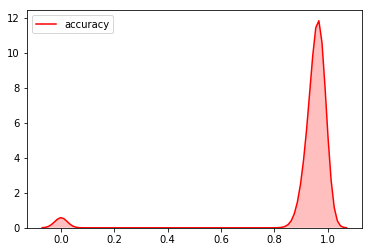

In [11]:
sns.kdeplot(df_sim['accuracy'], shade=True, color="r")

In [14]:
df_sim.columns


Index(['total_tasks', 'total_workers', 'proportion_hard_tasks',
       'proportion_train_tasks', 'workers_per_task', 'total_keys', 'alpha',
       'accuracy'],
      dtype='object')

In [15]:
df_sim.sort_values('accuracy', ascending=False)

,total_tasks,total_workers,proportion_hard_tasks,proportion_train_tasks,workers_per_task,total_keys,alpha,accuracy
1591,60,50,0.8,0.2,3,7,6,1.0000
8792,80,100,0.4,0.2,3,7,9,1.0000
3317,60,80,0.8,0.2,3,5,9,1.0000
1772,60,60,0.2,0.4,3,7,9,1.0000
2177,60,60,0.8,0.2,5,7,9,1.0000
2993,60,80,0.2,0.8,3,5,9,1.0000
548,60,30,0.8,0.8,3,7,9,1.0000
872,60,40,0.6,0.2,3,7,9,1.0000
2777,60,70,0.8,0.4,3,5,9,1.0000
2237,60,60,0.8,0.6,3,5,9,1.0000


In [17]:
#sns.kdeplot(df_sim['total_tasks'])

In [9]:
top = df_sim.sort_values('accuracy', ascending=False).head(100)

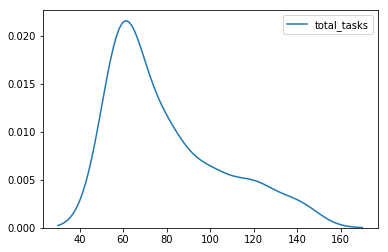

In [13]:
sns.kdeplot(top['total_tasks'])

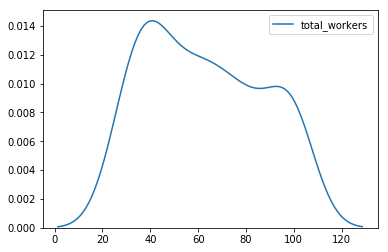

In [14]:
sns.kdeplot(top['total_workers'])

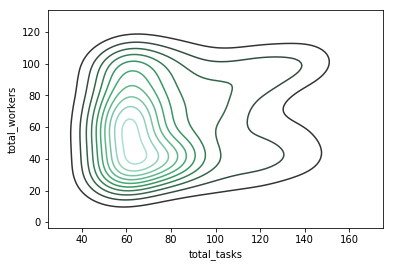

In [32]:
sns.kdeplot(top['total_tasks'], top['total_workers'])

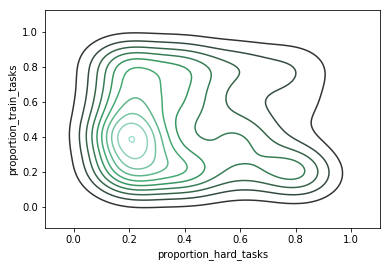

In [33]:
sns.kdeplot(top['proportion_hard_tasks'],top['proportion_train_tasks'])

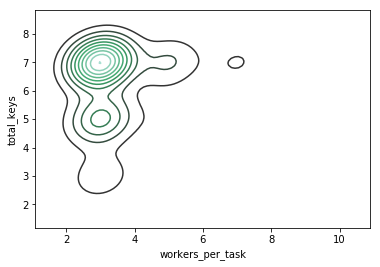

In [31]:
sns.kdeplot(top['workers_per_task'],top['total_keys'])

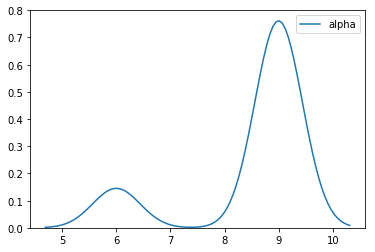

In [30]:
sns.kdeplot(top['alpha'])